# PyTorch: Image Classify Binary

*Brain Tumor Detection via Binary Classification of Magnetic Resonance Imaging (MRI) Scans*

<img src="../../../_static/images/banner/brains.png" class="banner-photo"/>

## Example Data

Reference [Example Datasets](../../datasets.html) for more information.

This dataset is comprised of:

* *Features* = folder of magnetic resonance imaging (MRI) of brain samples.
* *Labels* = tabular data denoting the presence of a tumor.

In [3]:
from aiqc import datum
from aiqc.orm import Dataset

In [4]:
df = datum.to_df('brain_tumor.csv')
dataset_label = Dataset.Tabular.from_df(df)

In [5]:
dataset_label.to_df().head(3)

status  size  count symmetry  \
0       0     0      0     None   
1       0     0      0     None   
2       0     0      0     None   

                                                 url  
0  https://raw.githubusercontent.com/aiqc/aiqc/ma...  
1  https://raw.githubusercontent.com/aiqc/aiqc/ma...  
2  https://raw.githubusercontent.com/aiqc/aiqc/ma...

In [6]:
urls = datum.get_remote_urls(manifest_name='brain_tumor.csv')
dataset_img = Dataset.Image.from_urls_pillow(urls)

🖼️ Ingesting Images 🖼️: 100%|████████████████████████| 80/80 [00:14<00:00,  5.59it/s]


In [7]:
images_pillow = dataset_img.to_pillow(samples=[6,47])

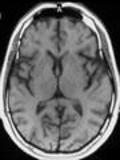

In [8]:
images_pillow[0]

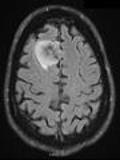

In [9]:
images_pillow[1]

---

## Pipeline

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [10]:
from aiqc.mlops import Pipeline, Input, Target, Stratifier
from sklearn.preprocessing import FunctionTransformer
from aiqc.utils.encoding import div255, mult255

In [11]:
pipeline = Pipeline(
    Input(
        dataset         = dataset_img,
        encoders        = Input.Encoder(FunctionTransformer(div255, inverse_func=mult255)),
        reshape_indices = (0,2,3)#reshape for Conv1D grayscale.
    ),
        
    Target(
        dataset = dataset_label,
        column  = 'status'
    ),

    Stratifier(
        size_test       = 0.14,
        size_validation = 0.22
    )
)

---

## Modeling

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [12]:
from aiqc.mlops import Experiment, Architecture, Trainer
import torch.nn as nn
import torchmetrics as tm
from aiqc.utils.pytorch import fit

In [13]:
def fn_build(features_shape, label_shape, **hp):
    model = nn.Sequential(
        nn.Conv1d(
            in_channels=features_shape[0], out_channels=hp['filters']*4,
            kernel_size=hp['kernel_size'], padding='same'
        )
        , nn.ReLU() #wasnt learning with tanh
        , nn.MaxPool1d(kernel_size=2)
        , nn.Dropout(p=0.4)

        , nn.Conv1d(
            in_channels=hp['filters']*4, out_channels=hp['filters']*3,
            kernel_size=hp['kernel_size'], padding='same'
        )
        , nn.ReLU() #wasnt learning with tanh
        , nn.MaxPool1d(kernel_size=2)
        , nn.Dropout(p=0.4)
        
        , nn.Conv1d(
            in_channels=hp['filters']*3, out_channels=hp['filters']*2,
            kernel_size=hp['kernel_size'], padding='same'
        )
        , nn.ReLU() #wasnt learning with tanh
        , nn.MaxPool1d(kernel_size=2)
        , nn.Dropout(p=0.4)
        
        
        , nn.Flatten()
        , nn.Linear(720,32)#in,out
        , nn.BatchNorm1d(32,32)
        , nn.ReLU()
        , nn.Dropout(p=0.4)

        , nn.Linear(32,label_shape[0])
        , nn.Sigmoid()
    )
    return model

In [14]:
def fn_train(
    model, loser, optimizer,
    train_features, train_label,
    eval_features, eval_label,
    **hp
):
    model = fit(
        model, loser, optimizer, 
        train_features, train_label,
        eval_features, eval_label
        , epochs     = hp['epochs']
        , batch_size = hp['batch_size']
        , metrics    = [tm.Accuracy(), tm.F1Score()]
    )
    return model

In [15]:
hyperparameters = dict(
    filters       = [24]
    , kernel_size = [5,8]
    , epochs      = [50]
    , batch_size  = [5]
)

In [18]:
experiment = Experiment(
    Architecture(
        library           = "pytorch"
        , analysis_type   = "classification_binary"
        , fn_build        = fn_build
        , fn_train        = fn_train
        , hyperparameters = hyperparameters
    ),
    
    Trainer(pipeline=pipeline, repeat_count=2)
)

In [19]:
experiment.run_jobs()

🔮 Training Models 🔮:  25%|██████████▌                               | 1/4 [00:09<00:28,  9.51s/it]/Users/layne/.pyenv/versions/3.7.12/envs/aiqc_dev/lib/python3.7/site-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)
🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 4/4 [00:40<00:00, 10.08s/it]


---

## Visualization & Interpretation

For more information on visualization of performance metrics, reference the [Dashboard](../../dashboard.html) documentation.